In [ ]:
#  Import Necessary Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import PDB
from Bio.PDB import PDBParser
import nglview as nv
import seaborn as sns
import random
import math
import torch
import torch.nn as nn
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer,make_column_transformer
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [3]:

# Load the data
file_path = '/Users/kavishdaftari/Downloads/archive (5)/pdb_data_no_dups.csv' 
pdb_data_no_dups = pd.read_csv(file_path)

# Inspect the data
print(pdb_data_no_dups.head())
print(pdb_data_no_dups.info())


# Now, 'encoded_sequences' is a numpy array with the one-hot encoded protein sequences
# You can add these as columns to your DataFrame or use them as input to your models

  structureId         classification experimentalTechnique macromoleculeType  \
0        100D         DNA-RNA HYBRID     X-RAY DIFFRACTION    DNA/RNA Hybrid   
1        101D                    DNA     X-RAY DIFFRACTION               DNA   
2        101M       OXYGEN TRANSPORT     X-RAY DIFFRACTION           Protein   
3        102D                    DNA     X-RAY DIFFRACTION               DNA   
4        102L  HYDROLASE(O-GLYCOSYL)     X-RAY DIFFRACTION           Protein   

   residueCount  resolution  structureMolecularWeight  \
0            20        1.90                   6360.30   
1            24        2.25                   7939.35   
2           154        2.07                  18112.80   
3            24        2.20                   7637.17   
4           165        1.74                  18926.61   

           crystallizationMethod  crystallizationTempK  densityMatthews  \
0  VAPOR DIFFUSION, HANGING DROP                   NaN             1.78   
1                         

In [4]:
# Load the data
file_path = '/Users/kavishdaftari/Downloads/archive (5)/pdb_data_seq.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Inspect the data
print(df.head())
print(df.info())

# Example: Clean the data (this step depends on your specific data)
# Remove rows with missing or invalid sequences
df = df[df['sequence'].notnull()]  # Replace 'sequence_column' with your column name

# Example: Clean the data (this step depends on your specific data)
# Remove rows with missing or invalid sequences
df = df[df['sequence'].notnull()]  # Replace 'sequence_column' with your column name
# Add more cleaning steps as needed

# Encode the sequences
# This is a simple example of encoding. Adapt as needed for your case.
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Assume each sequence is a string of characters (amino acids)
# The encoder expects a 2D array, so we need to reshape
sequences = df['sequence'].values.reshape(-1, 1)  # Replace 'sequence_column' with your column name

# Fit and transform
encoder.fit(sequences)
encoded_sequences = encoder.transform(sequences)


  structureId chainId                                           sequence  \
0        100D       A                                         CCGGCGCCGG   
1        100D       B                                         CCGGCGCCGG   
2        101D       A                                       CGCGAATTCGCG   
3        101D       B                                       CGCGAATTCGCG   
4        101M       A  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...   

   residueCount macromoleculeType  
0            20    DNA/RNA Hybrid  
1            20    DNA/RNA Hybrid  
2            24               DNA  
3            24               DNA  
4           154           Protein  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467304 entries, 0 to 467303
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        467304 non-null  object
 1   chainId            467294 non-null  object
 2   sequence           4

In [5]:
# Extracting the 'structureId' column to create a list of structure IDs
structure_ids = df['structureId'].unique()

# Convert the numpy array to a list and display the first few entries
pdb_ids_list = structure_ids.tolist()
  # Displaying the first 10 for brevity

In [6]:
from requests import get
import os

def download_pdb(pdb_id: str, download_dir: str = os.path.join(os.path.expanduser('~/'), 'Downloads')) -> None:
    try:
        r = get(f"https://files.rcsb.org/download/{pdb_id.upper()}.pdb")
        r.raise_for_status()  # Raises an HTTPError if the HTTP request returned an unsuccessful status code
        file_path = os.path.join(download_dir, f"{pdb_id.upper()}.pdb")
        with open(file_path, 'w') as file:
            file.write(r.text)
    except Exception as e:
        print(f"Error downloading {pdb_id}: {e}")

pdbids: list[str] = pdb_ids_list[0:100]  # Assuming 'pdb_ids_list' is already defined and contains all the structure IDs
for pdbid in pdbids:
    download_pdb(pdb_id=pdbid, download_dir='/Users/kavishdaftari/Downloads/obsolete')  # Replace 'path/to/dir' with your desired directory


In [7]:
seq = df

seq.head(10)

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
5,102D,A,CGCAAATTTGCG,24,DNA
6,102D,B,CGCAAATTTGCG,24,DNA
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
9,103D,A,GTGGAATGGAAC,24,DNA


In [8]:
seq.describe()

,residueCount
count,467276.000000
mean,6173.792442
std,23646.220890
min,2.000000
25%,456.000000
50%,1131.000000
75%,4342.000000
max,313236.000000


In [9]:
structure = pd.read_csv('/Users/kavishdaftari/Downloads/archive (5)/pdb_data_no_dups.csv')
structure.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [10]:
structure.describe()

,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear
count,141401.000000,128589.000000,1.414010e+05,97039.000000,124724.000000,124749.000000,105110.000000,117602.000000
mean,825.374849,2.263807,1.120790e+05,290.967713,2.670267,51.353163,6.788685,2008.922365
std,2136.461080,1.410878,5.690152e+05,9.541080,0.783740,10.104561,2.556819,8.459286
min,0.000000,0.480000,3.143800e+02,4.000000,0.000000,0.000000,0.000000,201.000000
25%,226.000000,1.800000,2.612856e+04,290.000000,2.210000,44.370000,6.000000,2005.000000
50%,414.000000,2.100000,4.747779e+04,293.000000,2.490000,50.500000,7.000000,2010.000000
75%,820.000000,2.500000,9.408484e+04,295.000000,2.910000,57.710000,7.500000,2014.000000
max,313236.000000,70.000000,9.773054e+07,398.000000,99.000000,92.000000,724.000000,2018.000000


In [11]:
df = seq.set_index('structureId').merge(structure.set_index('structureId'),on='structureId',how='left')
df = df.reset_index()
df.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
2,101D,A,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
3,101D,B,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount_x,471121.0,6258.299679,2.361904e+04,2.00,456.00,1140.00,4536.00,313236.0
residueCount_y,471121.0,6258.299679,2.361904e+04,2.00,456.00,1140.00,4536.00,313236.0
resolution,449471.0,3.020670,3.091269e+00,0.48,2.00,2.50,3.10,70.0
structureMolecularWeight,471121.0,926168.734152,3.018924e+06,453.55,52771.93,131147.75,635323.06,97730536.0
crystallizationTempK,317693.0,290.889723,8.785213e+00,4.00,291.00,293.00,295.00,398.0
densityMatthews,389641.0,2.850780,8.243949e-01,0.00,2.32,2.67,3.19,99.0
densityPercentSol,389763.0,54.199064,1.026965e+01,0.00,46.89,53.95,61.37,92.0
phValue,340691.0,6.830610,2.461787e+00,0.00,6.10,7.00,7.50,724.0
publicationYear,413487.0,2010.484779,6.995774e+00,201.00,2007.00,2012.00,2015.00,2018.0


In [13]:
df.dropna(inplace=True)
df.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
5,102D,A,CGCAAATTTGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
6,102D,B,CGCAAATTTGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
45,110D,A,CGGCCG,6,DNA,DNA,X-RAY DIFFRACTION,DNA,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,2.90,57.63,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1993.0
48,111D,A,CGCAAATTGGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0
49,111D,B,CGCAAATTGGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0


In [14]:
df['sequence']= df['sequence'].astype(str).apply(lambda x : ' '.join(x))
new_df = df.loc[:, [col for col in df.columns if col not in  ['chainId','structureId']]]
seq_vec = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
tst = seq_vec.fit_transform(df['sequence'])


In [15]:
seq_chars = pd.DataFrame(tst.todense(),columns=seq_vec.get_feature_names_out(),index=new_df.index)
seq_chars.nunique()

a    188
b      3
c    110
d    117
e    135
f     89
g    173
h     55
i    129
k    133
l    179
m     54
n    120
o      2
p     97
q     94
r    109
s    136
t    114
u     97
v    132
w     42
x    125
y     84
z      3
dtype: int64

In [16]:
columns = ['sequence','residueCount_x','macromoleculeType_x','residueCount_y','densityPercentSol','macromoleculeType_y','structureMolecularWeight','experimentalTechnique','resolution','crystallizationMethod','crystallizationTempK','densityMatthews','pdbxDetails','phValue','publicationYear']

numeric_features = ['residueCount_x','residueCount_y','resolution','structureMolecularWeight','crystallizationTempK','densityMatthews','densityPercentSol',
                   'phValue','publicationYear']
numeric_transformer = StandardScaler()

categorical_features = ['macromoleculeType_x','experimentalTechnique','macromoleculeType_y','crystallizationMethod','pdbxDetails']
                       
categorical_transformer = OrdinalEncoder()

In [17]:
seq_chars = seq_chars.drop(['b','o','z'],axis=1)
seq_chars.head()

,a,c,d,e,f,g,h,i,k,l,...,p,q,r,s,t,u,v,w,x,y
5,3,3,0,0,0,3,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
6,3,3,0,0,0,3,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
45,0,3,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,3,3,0,0,0,4,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
49,3,3,0,0,0,4,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [18]:
new_df[seq_chars.columns] = seq_chars
new_df = new_df.drop('sequence',axis=1)
new_df.head()

,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,...,p,q,r,s,t,u,v,w,x,y
5,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,3,0,0,0,0,0
6,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,3,0,0,0,0,0
45,6,DNA,DNA,X-RAY DIFFRACTION,DNA,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,0,0,0,0,0,0
48,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,2,0,0,0,0,0
49,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,...,0,0,0,0,2,0,0,0,0,0


In [19]:
transformed_numeric = numeric_transformer.fit_transform(new_df[numeric_features])
transformed_categ = categorical_transformer.fit_transform(new_df[categorical_features])
transformed_seq = numeric_transformer.fit_transform(new_df[seq_chars.columns])

In [20]:
new_df[numeric_features] = transformed_numeric
new_df[categorical_features] = transformed_categ
new_df[seq_chars.columns] = transformed_seq
X = new_df.drop('classification',axis=1)  
y = new_df.classification

In [21]:
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount_x,215142.0,-2.522467e-14,1.000002,-0.483345,-0.430975,-0.369471,-0.144961,9.823691
macromoleculeType_x,215142.0,4.738824e+00,1.787322,0.000000,4.000000,4.000000,4.000000,12.000000
experimentalTechnique,215142.0,5.999391e+00,0.054239,0.000000,6.000000,6.000000,6.000000,8.000000
macromoleculeType_y,215142.0,4.738824e+00,1.787322,0.000000,4.000000,4.000000,4.000000,12.000000
residueCount_y,215142.0,-2.522467e-14,1.000002,-0.483345,-0.430975,-0.369471,-0.144961,9.823691
resolution,215142.0,9.746822e-15,1.000002,-2.686965,-0.699109,-0.090582,0.585559,9.510626
structureMolecularWeight,215142.0,3.410125e-15,1.000002,-0.442822,-0.408799,-0.369411,-0.224608,7.635687
crystallizationMethod,215142.0,1.824071e+02,31.398226,0.000000,183.000000,183.000000,197.000000,405.000000
crystallizationTempK,215142.0,5.623498e-16,1.000002,-33.182106,0.004772,0.236040,0.467307,12.377581
densityMatthews,215142.0,-1.946180e-15,1.000002,-3.784181,-0.710578,-0.222495,0.489842,12.968935


<AxesSubplot:>

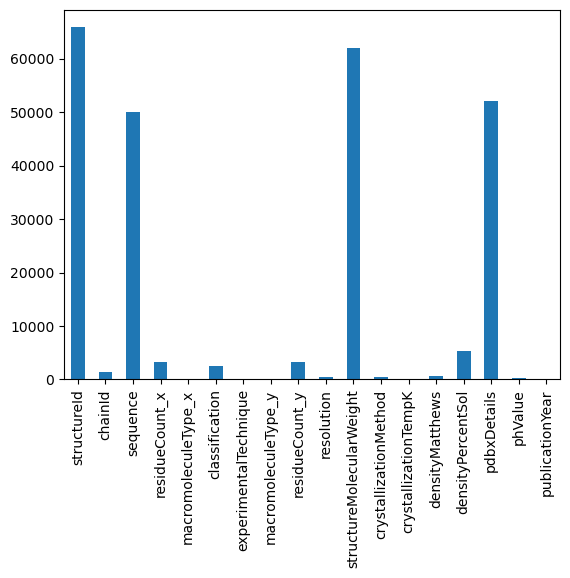

In [22]:
df.nunique().plot(kind='bar')

<AxesSubplot:>

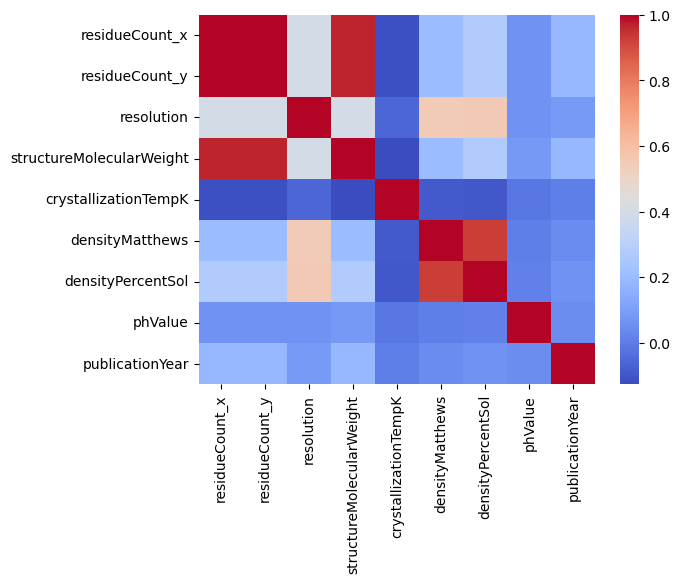

In [23]:
sns.heatmap(df.corr(),cmap='coolwarm')

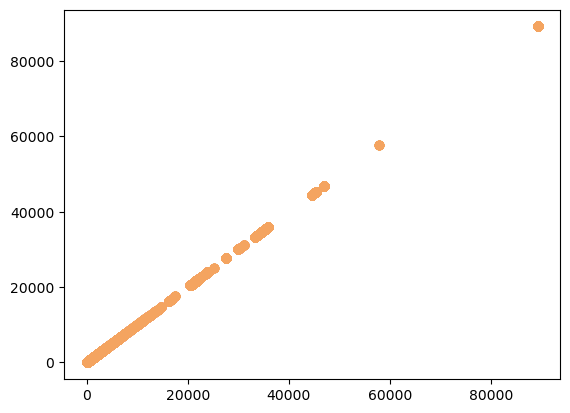

In [24]:
plt.scatter(x=df['residueCount_x'],y=df['residueCount_y'],color='sandybrown',alpha=0.8)

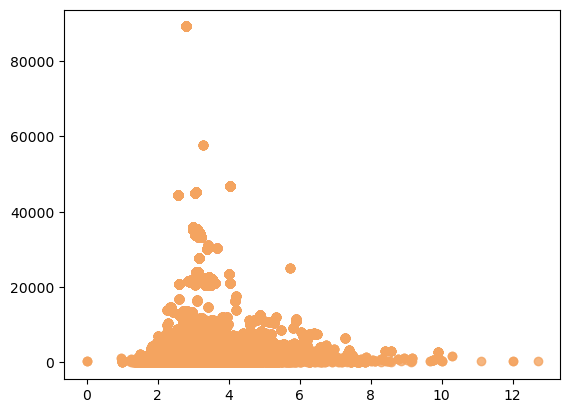

In [25]:
plt.scatter(x=df['densityMatthews'],y=df['residueCount_y'],color='sandybrown',alpha=0.8)

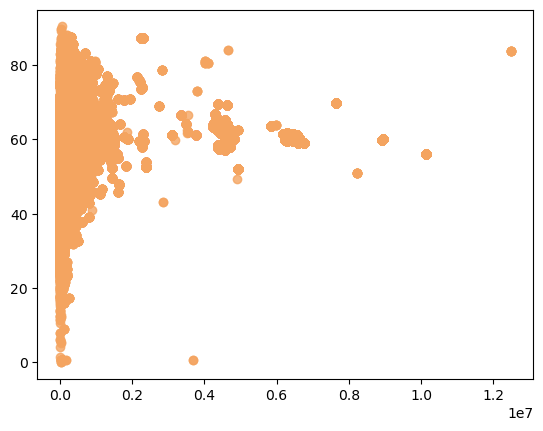

In [26]:
plt.scatter(x=df['structureMolecularWeight'],y=df['densityPercentSol'],color='sandybrown',alpha=0.8)

<AxesSubplot:>

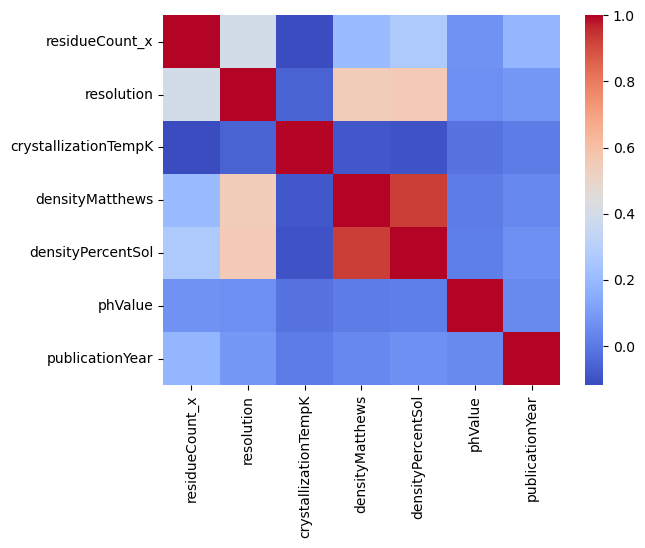

In [27]:

df = df.drop(['residueCount_y','structureMolecularWeight','macromoleculeType_y','pdbxDetails'],axis=1)

sns.heatmap(df.corr(),cmap='coolwarm')

In [28]:
new_df = new_df.drop(['residueCount_y','structureMolecularWeight','macromoleculeType_y','pdbxDetails'],axis=1)

In [29]:
new_df['classification'].value_counts()

HYDROLASE                               23115
RIBOSOME                                19120
TRANSFERASE                             18270
OXIDOREDUCTASE                          17037
IMMUNE SYSTEM                            9712
                                        ...  
RNA BINDING PROTEIN, PROTEIN BINDING        1
actin-binding protein                       1
DRUG/DNA                                    1
Cell Adhesion, Membrane Protein             1
lipid transport/activator                   1
Name: classification, Length: 2511, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'HYDROLASE'),
  Text(1, 0, 'RIBOSOME'),
  Text(2, 0, 'TRANSFERASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'IMMUNE SYSTEM'),
  Text(5, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(6, 0, 'LYASE'),
  Text(7, 0, 'TRANSCRIPTION'),
  Text(8, 0, 'TRANSPORT PROTEIN'),
  Text(9, 0, 'VIRAL PROTEIN')])

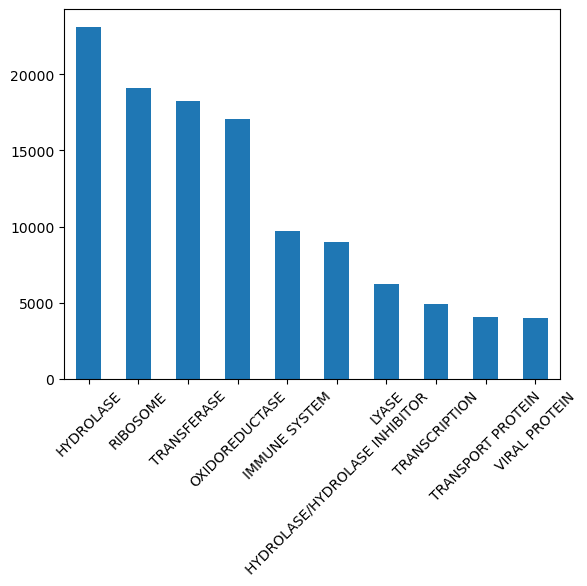

In [30]:
# getting top 10 classes
new_df['classification'].value_counts()[:10].plot(kind='bar')
plt.xticks(rotation=45)

In [31]:
counts = new_df.classification.value_counts()
data = np.asarray(counts[(counts > 11000)].index)

In [32]:
data = new_df[new_df.classification.isin(data)]
data.head()

,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,resolution,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,...,p,q,r,s,t,u,v,w,x,y
916,-0.440686,4.0,OXIDOREDUCTASE,6.0,0.179875,183.0,-1.6141,-0.750152,-0.773584,1.231901,...,0.859013,-0.112606,-0.054288,0.827637,0.937911,-0.063242,1.537017,-0.042147,-0.014862,-0.537077
2185,-0.437449,4.0,OXIDOREDUCTASE,6.0,-0.766723,321.0,-1.6141,-1.079938,-2.244163,-0.565332,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645
2186,-0.437449,4.0,OXIDOREDUCTASE,6.0,-0.766723,321.0,-1.6141,-1.079938,-2.244163,-0.565332,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645
2187,-0.437449,4.0,OXIDOREDUCTASE,6.0,-1.172408,321.0,-1.6141,-1.093129,-2.224317,-0.526262,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645
2188,-0.437449,4.0,OXIDOREDUCTASE,6.0,-1.172408,321.0,-1.6141,-1.093129,-2.224317,-0.526262,...,-0.198891,-0.350688,-0.676519,-0.376909,-0.649386,-0.063242,-0.412778,0.968337,-0.014862,0.098645


In [33]:
data.classification.value_counts()

HYDROLASE         23115
RIBOSOME          19120
TRANSFERASE       18270
OXIDOREDUCTASE    17037
Name: classification, dtype: int64

<AxesSubplot:>

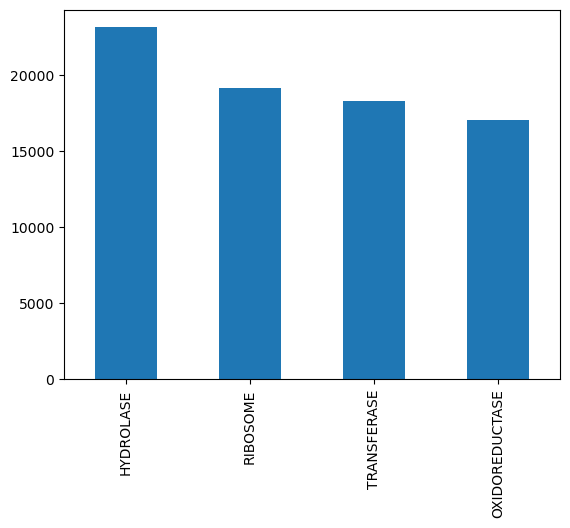

In [34]:
data.classification.value_counts().plot(kind='bar')

In [35]:
# Function to read protein sequences from PDB files
def read_pdb_files(folder_path):
    parser = PDB.PDBParser(QUIET=True)
    sequences = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".pdb"):
            path = os.path.join(folder_path, filename)
            structure = parser.get_structure(id=filename, file=path)
            
            for model in structure:
                for chain in model:
                    seq = [res.get_resname() for res in chain]
                    sequences.append("".join(seq))
    
    return sequences


In [36]:
# Main execution
folder_path = '/Users/kavishdaftari/Downloads/obsolete'  # Replace with your folder path
sequences = read_pdb_files(folder_path)
# train, val, test = split_dataset(sequences)
# visualize_split(train, val, test)

In [37]:
# Function to split the dataset
def split_dataset(sequences):
    train, test = train_test_split(sequences, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
    return train, val, test

# Function to visualize the data split
def visualize_split(train, val, test):
    sizes = [len(train), len(val), len(test)]
    labels = ['Train', 'Validation', 'Test']
    
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Dataset Split')
    plt.show()
import random

def split_dataset(data, train_frac=0.7, val_frac=0.15):
    random.shuffle(data)
    train_size = int(len(data) * train_frac)
    val_size = int(len(data) * val_frac)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data

train, val, test = split_dataset(sequences)


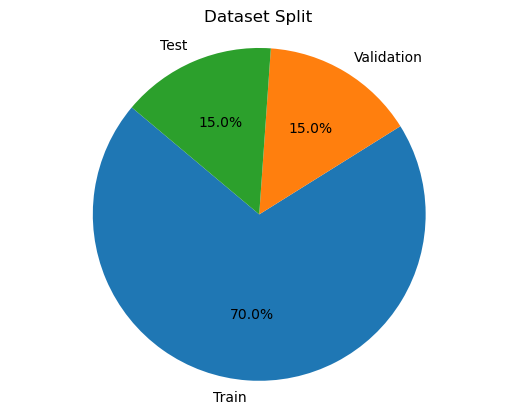

In [38]:
train, val, test = split_dataset(sequences)
visualize_split(train, val, test)

In [39]:
pdb_files = [f for f in os.listdir(folder_path) if f.endswith('.pdb')]
pdb_files = sorted(pdb_files)[:10]  # Get the first 10 PDB files


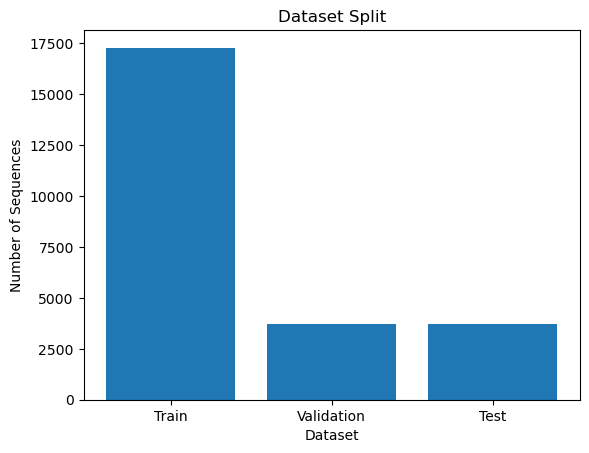

In [40]:


def visualize_split(train, val, test):
    sizes = [len(train), len(val), len(test)]
    labels = ['Train', 'Validation', 'Test']

    plt.bar(labels, sizes)
    plt.xlabel('Dataset')
    plt.ylabel('Number of Sequences')
    plt.title('Dataset Split')
    plt.show()

visualize_split(train, val, test)


In [41]:
parser = PDBParser()

for pdb_file in pdb_files:
    file_path = os.path.join(folder_path, pdb_file)
    structure = parser.get_structure(pdb_file, file_path)
    view = nv.show_biopython(structure)
    display(view)  # This will display the structure


/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 764.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 816.
  warnings.warn(


NGLWidget()

/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 869.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 870.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 901.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 915.
  warnings.warn(


NGLWidget()

NGLWidget()

/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 870.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 908.
  warnings.warn(


NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

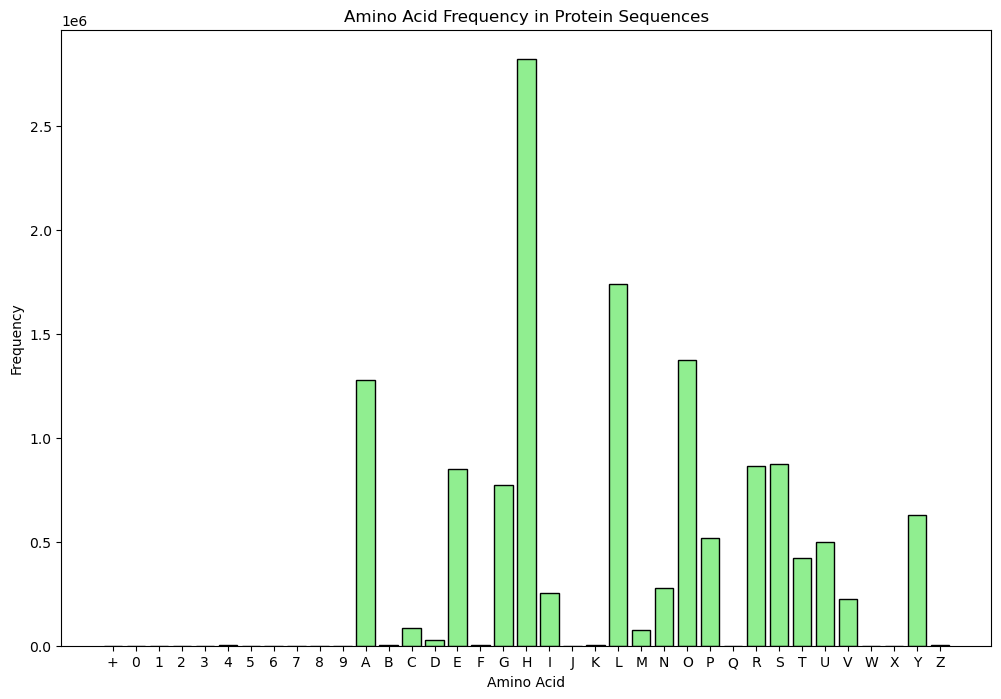

In [42]:
from collections import Counter

# Calculate frequency of each amino acid
amino_acid_freq = Counter("".join(sequences))

# Sort the amino acids
sorted_amino_acids = sorted(amino_acid_freq.keys())
frequencies = [amino_acid_freq[aa] for aa in sorted_amino_acids]

plt.figure(figsize=(12, 8))
plt.bar(sorted_amino_acids, frequencies, color='lightgreen', edgecolor='black')
plt.title('Amino Acid Frequency in Protein Sequences')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.show()


In [ ]:


# Example property mapping
property_mapping = {
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8,
    'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
}

# Padding sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = [seq.ljust(max_length, 'X') for seq in sequences]  # 'X' represents a padding character

# Convert sequences to numerical values
properties_matrix = np.array([[property_mapping.get(aa, 0) for aa in seq] for seq in padded_sequences])

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(properties_matrix, cmap='viridis')
plt.title('Heatmap of Biochemical Properties in Protein Sequences')
plt.xlabel('Position in Sequence')
plt.ylabel('Protein Index')
plt.show()


In [43]:
pdb_files = [f for f in os.listdir(folder_path) if f.endswith('.pdb')]
pdb_files = sorted(pdb_files)[:10]
# Dictionary to store atom names for each PDB file
all_atom_names = {}

# Iterate over each PDB file
for pdb_file in pdb_files:
    file_path = os.path.join(folder_path, pdb_file)
    
    # Parse the structure
    structure = parser.get_structure(pdb_file, file_path)

    # List to store atom names for the current file
    atom_names = []

    # Extract atom names
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_names.append(atom.get_name())

    # Store the atom names in the dictionary
    all_atom_names[pdb_file] = atom_names

# Now, all_atom_names contains atom names for each file
for pdb_file, atoms in all_atom_names.items():
    print(f"Atom names in {pdb_file}: {atoms}")


Atom names in 100D.pdb: ["O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "O2'", "C1'", 'N1', 'C2', 'O2', 'N3', 'C4', 'N4', 'C5', 'C6', 'P', 'OP1', 'OP2', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "C1'", 'N1', 'C2', 'O2', 'N3', 'C4', 'N4', 'C5', 'C6', 'P', 'OP1', 'OP2', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "C1'", 'N9', 'C8', 'N7', 'C5', 'C6', 'O6', 'N1', 'C2', 'N2', 'N3', 'C4', 'P', 'OP1', 'OP2', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "C1'", 'N9', 'C8', 'N7', 'C5', 'C6', 'O6', 'N1', 'C2', 'N2', 'N3', 'C4', 'P', 'OP1', 'OP2', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "C1'", 'N1', 'C2', 'O2', 'N3', 'C4', 'N4', 'C5', 'C6', 'P', 'OP1', 'OP2', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "C1'", 'N9', 'C8', 'N7', 'C5', 'C6', 'O6', 'N1', 'C2', 'N2', 'N3', 'C4', 'P', 'OP1', 'OP2', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "C1'", 'N1', 'C2', 'O2', 'N3', 'C4', 'N4', 'C5', 'C6', 'P', 'OP1', 'OP2', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "C1'

/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 764.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 816.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 869.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 870.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 901.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/Bio/PDB/StructureBuild

In [44]:

# Initialize Distributed Training Environment
def setup(rank, world_size):
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

class ComplexProteinModel(nn.Module):
    def __init__(self, num_tokens, d_model, nhead, num_transformer_layers, dim_feedforward, max_seq_len, num_classes):
        super(ComplexProteinModel, self).__init__()
        self.d_model = d_model

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(num_tokens, d_model)

        # Positional encoding for sequence data
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_transformer_layers)

        # Dense layers for classification or regression at the end
        self.fc1 = nn.Linear(max_seq_len * d_model, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Embedding and positional encoding
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]

        # Transformer
        x = self.transformer_encoder(x)

        # Flatten and pass through dense layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

def train(rank, world_size, epochs):
    setup(rank, world_size)

    # Prepare your model
    model = ComplexProteinModel.to(rank)
    model = DDP(model, device_ids=[rank])

    # Data loaders with DistributedSampler
    transform = transforms.Compose([transforms.ToTensor(), ...])
    dataset = datasets.YourDataset("data_path", transform=transform)
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank)
    data_loader = DataLoader(dataset, batch_size=64, sampler=sampler)

    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(epochs):
        for data, target in data_loader:
            data, target = data.to(rank), target.to(rank)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} completed")


In [45]:
# Hyperparameter tuning can be a complex process and might require a separate script.
# Here's a simple example using a grid search approach.

from itertools import product

# Define a range of hyperparameters
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]

# Grid search
for lr, batch_size in product(learning_rates, batch_sizes):
    print(f"Training with lr: {lr}, batch_size: {batch_size}")
    


Training with lr: 0.01, batch_size: 32
Training with lr: 0.01, batch_size: 64
Training with lr: 0.01, batch_size: 128
Training with lr: 0.001, batch_size: 32
Training with lr: 0.001, batch_size: 64
Training with lr: 0.001, batch_size: 128
Training with lr: 0.0001, batch_size: 32
Training with lr: 0.0001, batch_size: 64
Training with lr: 0.0001, batch_size: 128


In [46]:
def evaluate(model, test_loader, device):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')




In [47]:

# Load the datasets
pdb_data_no_dups = pd.read_csv('/Users/kavishdaftari/Downloads/archive (5)/pdb_data_no_dups.csv')
pdb_data_seq = pd.read_csv('/Users/kavishdaftari/Downloads/archive (5)/pdb_data_seq.csv')



# Feature extraction (this would be more complex in a real scenario)
# For simplicity, let's assume we're using the sequence length as a feature
pdb_data_seq.dropna(subset=['sequence'], inplace=True)

pdb_data_seq['sequence_length'] = pdb_data_seq['sequence'].apply(len)
# Merge the dataframes on 'structureId', including the sequence_length column
merged_data = pd.merge(pdb_data_seq[['structureId', 'sequence_length']], 
                       pdb_data_no_dups[['structureId', 'classification']], 
                       on='structureId')

# Assuming 'sequence_length' feature has already been created
X = merged_data[['sequence_length']]  # Features
y = LabelEncoder().fit_transform(merged_data['classification'])  # Labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

def train_and_evaluate(model, X, y):
    scores = cross_val_score(model, X, y, cv=5)
    return scores.mean()

# Define a list of models (or model configurations)
models = [RandomForestClassifier(n_estimators=10), RandomForestClassifier(n_estimators=50)]

# Parallel training and evaluation
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(model, X_train, y_train) for model in models)


/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/kavishdaftari/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
import time

def measure_training_time(model, X, y, n_jobs):
    start = time.time()
    Parallel(n_jobs=n_jobs)(delayed(train_and_evaluate)(model, X, y) for _ in range(10))
    end = time.time()
    return end - start

# Measure training time for different CPU configurations
times = [measure_training_time(RandomForestClassifier(n_estimators=50), X_train, y_train, n_jobs=i) for i in [1, 2, 4, 8]]

# Calculate speedup and efficiency
baseline_time = times[0]
speedup = [baseline_time / t for t in times]
efficiency = [s / n for s, n in zip(speedup, [1, 2, 4, 8])]
# Creating the plots
plt.figure(figsize=(12, 6))

# Plot for Speedup
plt.subplot(1, 2, 1)
plt.plot(cpu_configs, speedup, marker='o', color='blue', linestyle='-', label='Speedup')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.title('Speedup vs Number of CPUs')
plt.grid(True)
plt.legend()

# Plot for Efficiency
plt.subplot(1, 2, 2)
plt.plot(cpu_configs, efficiency, marker='o', color='green', linestyle='-', label='Efficiency')
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.title('Efficiency vs Number of CPUs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()